## Phase 2

Part 1: Parse the o-contours

Using your code from Phase 1, add the parsing of the o-contours into your pipeline. Note that there are only half the number of o-contour files as there are i-contour files, so not every i-contour will have a corresponding o-contour.

After building the pipeline, please discuss any changes that you made to the pipeline you built in Phase 1, and why you made those changes.

* I expanded my 'slice dictionary' data structure to take both inner and outer contour masks if available
* For the purposes of this analysis, however, I excluded any dicom slices without both i-contour and o-contour masks
* I added some basic unit tests (but would like to add more given time)

Part 2: Heuristic LV Segmentation approaches

Let’s assume that you want to create a system to outline the boundary of the blood pool (i-contours), and you already know the outer border of the heart muscle (o-contours). Compare the differences in pixel intensities inside the blood pool (inside the i-contour) to those inside the heart muscle (between the i-contours and o-contours); 

1) Could you use a simple thresholding scheme to automatically create the i-contours, given the o-contours? Why or why not? Show figures that help justify your answer.

* Given the variation between patients and scanes, raw intensity distributions are unreliable
* I created an accuracy metric to evaluate my attempts and compare to a baselien prediction (the o-contour itself)
* (Results below)

Do you think that any other heuristic (non-machine learning)-based approaches, besides simple thresholding, would work in this case? Explain.

* I tried Canny Edges, K-Means, Contours, and Hough Circles
* I was able to improve on basic intensity thresholding with a combination of K-means with a simple polygon shape constraint
* (Results below)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom

import torch
import torchvision

import analysis
import config as cfg
import data_loader
import preprocess
import segmentation
import utils

### Dataset

In [3]:
TRAIN_PATIENTS = ['SCD0000101','SCD0000201','SCD0000301','SCD0000401']
TEST_PATIENTS = ['SCD0000501']

trn_slices = preprocess.create_dataset(cfg.PATIENT_LIST_FPATH, TRAIN_PATIENTS)
tst_slices = preprocess.create_dataset(cfg.PATIENT_LIST_FPATH, TEST_PATIENTS)

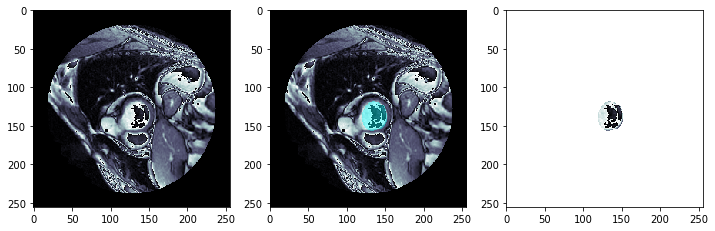

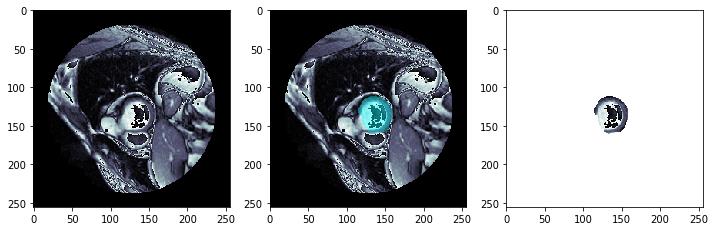

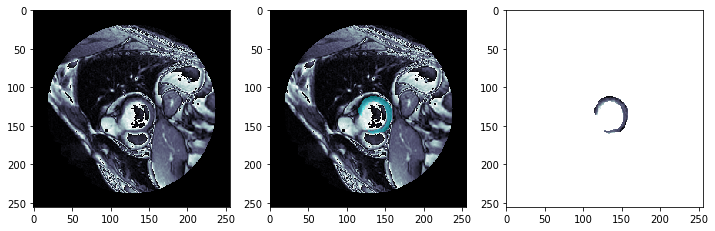

In [4]:
slice_data = preprocess.load_slice(trn_slices[0])

# Inner Contour
utils.plot_mask_overlay(slice_data['img'], slice_data['i_mask'])

# Outer Contour
utils.plot_mask_overlay(slice_data['img'], slice_data['o_mask'])

# Ring
utils.plot_mask_overlay(slice_data['img'], slice_data['io_mask'])

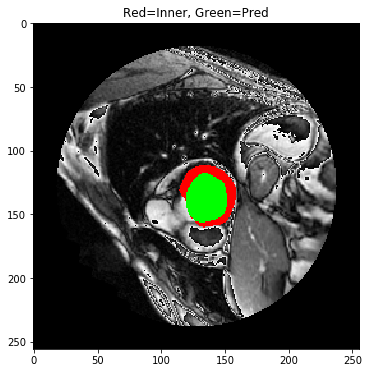

In [5]:
# Plot Inner and Outer Masks
slice_data = preprocess.load_slice(trn_slices[0])
img = slice_data['img']
img3 = np.repeat(img, 3, axis=2)
o_mask = slice_data['o_mask'].squeeze()
i_mask = slice_data['i_mask'].squeeze()
utils.plot_masks(img, [o_mask, i_mask])

## Null Hypothesis

* Since we're given the o-contour masks, a good baseline prediction is the o-contour mask itself

In [6]:
# Use O-Contour as Prediction
for dct in trn_slices:
    data = preprocess.load_slice(dct)
    dct['i_pred'] = data['o_mask'].copy()

analysis.test_segmentation_technique(trn_slices, plot=False)

Mean/Med Accuracy 0.6171 0.6351


## Intensity Thresholding

Approach

* Use histograms to threshold pixel intensity ranges of LV ring and inner blood pool
* LV ring intensity ~= (40 - 80) 
* Blood pool intensity ~= (125 - 190)
   
Conclusion

* Intensity thresholding with cleanup (.83) beats baseline (.63)
* However, there is too much overlap in intensity ranges between LV right and blood pool for this to be a reliable technique

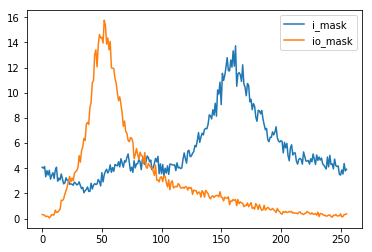

In [7]:
# Loop through all training slices and compute average intensity 
analysis.plot_mask_type_hists(trn_slices, bins=256)

Patient_Id SCD0000101


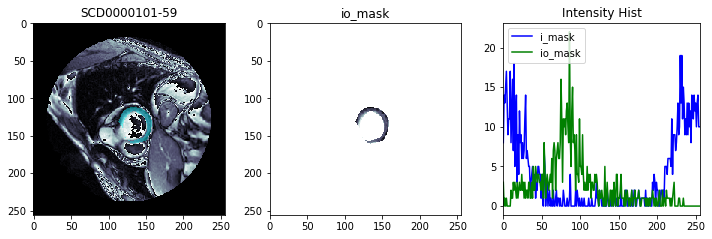

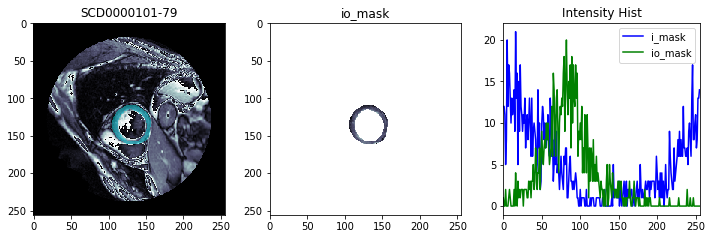

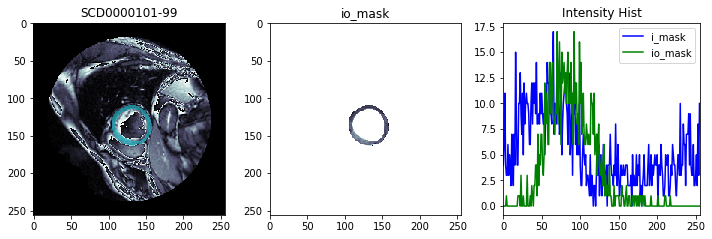

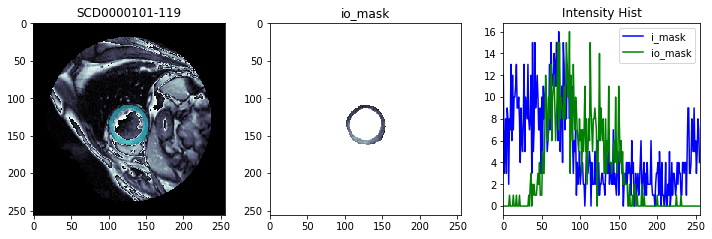

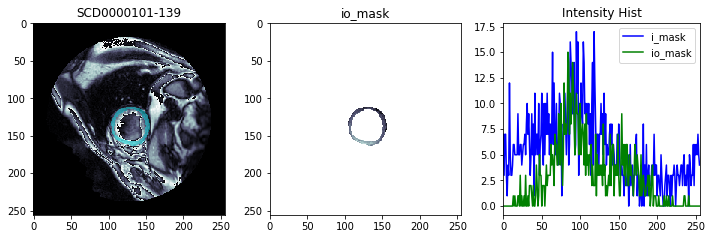

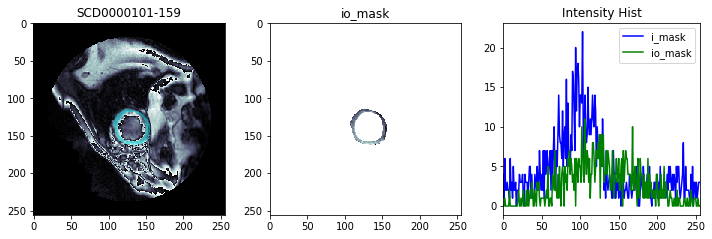

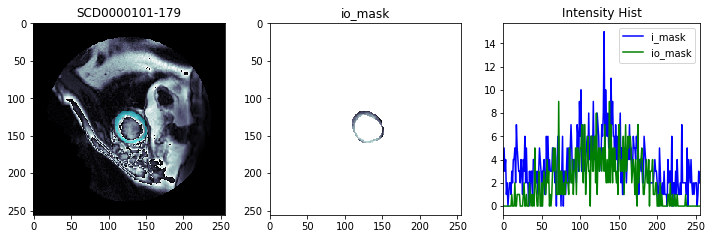

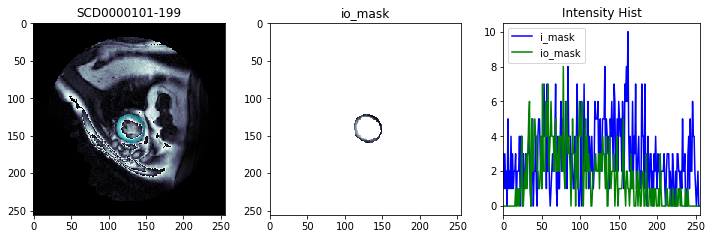

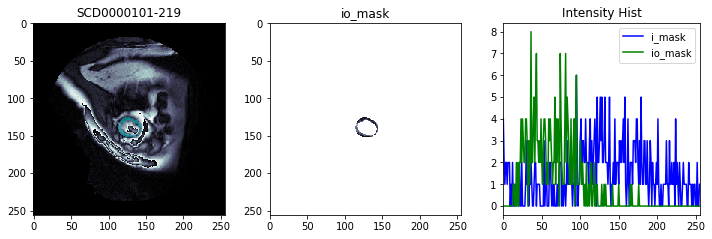

In [8]:
# Plot patient-level intensity histograms
analysis.plot_patient_slices(trn_slices, 'SCD0000101', bins=256)

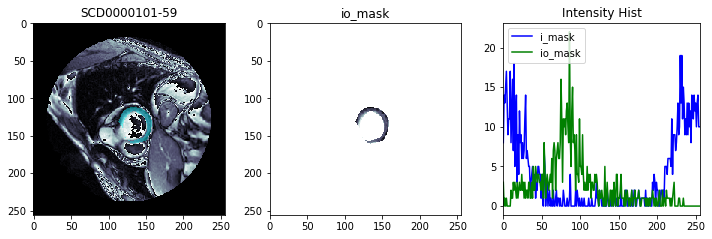

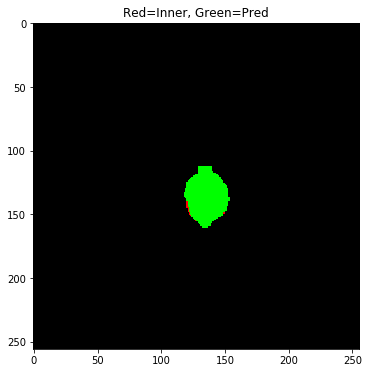

Accuracy 0.8647


In [14]:
# Threshold Single Image
slice_dict = trn_slices[0]
slice_data = preprocess.load_slice(slice_dict)
analysis.plot_slice(slice_dict, bins=256, figsize=(12, 12))
out = segmentation.threshold_segment(slice_data, low=40, high=100)
tmp = np.zeros(shape=(256,256,1))
utils.plot_masks(tmp, [slice_data['i_mask'], out])
print("Accuracy", analysis.accuracy(slice_data['o_mask'], slice_data['i_mask'], out))

In [15]:
# Threshold Dataset
trn_slices = segmentation.threshold_slices(trn_slices, low=40, high=100)
analysis.test_segmentation_technique(trn_slices, plot=False)

Mean/Med Accuracy 0.7914 0.8272


## K-Means

Approach

* Instead of thresholding raw pixel ranges, cluster the pixel ranges into 3 groups
* Dark, gray (LV outer ring), and light (Blood pool)
* Next, segment on the middle pixel value and clean
* Finally enforce a simple polygon constraint to simplify irregular shapes

Conclusion

* This obtains slightly better median accuracy (.84) vs thresholding (.82)


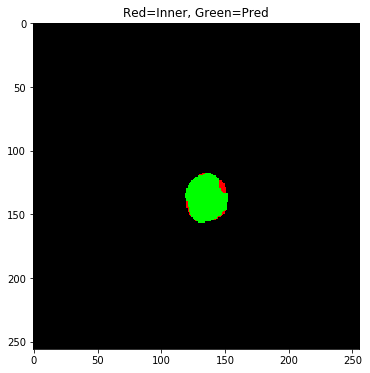

Accuracy 0.9351


In [16]:
slice_dct = trn_slices[0]
slice_data = preprocess.load_slice(slice_dct)
out,poly = segmentation.kmeans_segment(slice_dct)
tmp = np.zeros(shape=(256,256,1))
utils.plot_masks(tmp, [slice_data['i_mask'], out])
print("Accuracy", analysis.accuracy(slice_data['o_mask'], slice_data['i_mask'], poly))

In [17]:
# Threshold Dataset
for dct in trn_slices:
    out,poly = segmentation.kmeans_segment(dct)
    dct['i_pred'] = poly

analysis.test_segmentation_technique(trn_slices, plot=False)

Mean/Med Accuracy 0.8037 0.8406


## Hough Circles

Approach

* I thought it might be useful to take advantage of the circular nature of the inner contour, as well as its position inside the outer contour
* After completing K-Means, I passed the segmentation mask to a hough circle detector to return the best circle within the outer contour
* I set a conservative min and max radius tolerance to avoid false positives
* I then joined the hough circle mask with the original mask to "fill in the obvious gaps" that were missed by K-means

Conclusion

* I wasn't able to improve on the raw K-Means clustering segmentation

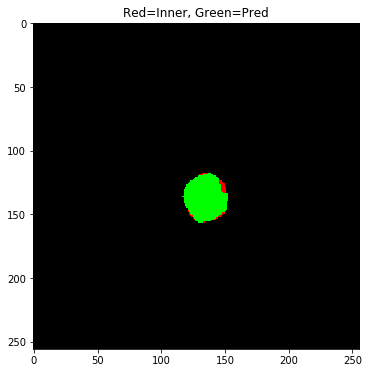

Accuracy 0.924


In [18]:
slice_dct = trn_slices[0]
slice_data = preprocess.load_slice(slice_dct)
out,poly = segmentation.kmeans_segment(slice_dct)
circles = segmentation.get_circles(slice_data, min_radius_pct=.3, max_radius_pct=.5)
circles = segmentation.fill_circles(poly, circles)

tmp = np.zeros(shape=(256,256,1))
utils.plot_masks(tmp, [slice_data['i_mask'], circles])
print("Accuracy", analysis.accuracy(slice_data['o_mask'], slice_data['i_mask'], circles))